# Data Visualisation using MatPlotLib
## Task C- 3 (a) Streaming data visualization
### Importing library


In [66]:
#!pip3 install folium

In [1]:
import re #imports regular expressions
from time import sleep  # for waiting 
from kafka import KafkaConsumer # for fetching the kafka data 
import datetime as dt   # creates timedelta
import matplotlib.pyplot as plt   # for plotting the live graphs and maps
import matplotlib.dates as mdates # plotting the time values
from pymongo import MongoClient  # fetching data from the mongodb
import pprint  # pretty print
import pandas as pd  
import json
import folium
import random
import re
#import folium  # for map plots
import statistics 
import pygeohash as gh

- Connecting to Kafka consumer to fetch the data by Kafka producers

In [2]:
def connect_kafka_consumer():   # kafla consumer with same topis as the kafka producer for climate data
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   #auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer


### Consume the data from Kafka producer and plot a line graph (LIVE)
- The plots are color coded on the basis of the last fetched data such as if the temp is high the line will be red , green for normal temprature and blue for low temp
- Minimum and Maximum value for last 10 consumed data are annoted in the graph.

In [3]:
topic = 'climate'
def consume_messages_and_plot(consumer):   #function to consume data and plot the graph
    try:
        %matplotlib notebook
        fig = plt.figure(figsize=(10,10))   #selecting figure size 
        cli = fig.add_subplot(111)          #creating subplots
        plt.ion()                           #for animating the graph  
        fig.show()
        fig.canvas.draw()
        x=[]   #empty lists
        y=[]
        # print('Waiting for messages')
        for message in consumer:       #for each value in consumer
            cli.clear()                #clear the graph for every iteration
            data = json.loads(message.value.decode('utf-8'))
            
            #import pdb;pdb.set_trace()
            at = data['air_temperature']
            x.append(float(at))     #appending the air Temprature
            y.append(dt.datetime.strptime((re.findall(r"\d\d:\d\d:\d\d",data['creation_time'])[0]),"%H:%M:%S"))#striping time from datetime data
            #colorcoding the graph red for higher temp green for normal and blue for low
            
            
            if float(at) >= 24:    
                cli.plot(y,x,color="red")
            elif float(at)< 24 and float(at) > 12:
                cli.plot(y,x,color="green")
            elif float(at)<= 12:
                cli.plot(y,x,color="blue")  
            plt.xlabel("Time")
            plt.ylabel("Temprature")
            #plotting the minimum and maximum values
            if len(x)>=2:
                index = x.index(max(x)) 
                xa = x[index] 
                xb = y[index]
                ma="Max:"+str(max(x))
                cli.annotate(ma,xy=(mdates.date2num(xb), xa))
                index = x.index(min(x)) 
                xa = x[index] 
                xb = y[index]
                mi="Min:"+str(min(x))
                cli.annotate(mi,xy=(mdates.date2num(xb), xa))
            plt.grid(True)
            fig.canvas.draw()
            
            if len(x)>10:
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
        #print("max={}\n min={}".format(max(x),min(x)), end="\r")
    except Exception as ex:
        print(str(ex))    

### (i) Line graph    `Air-temperature vs. arrival time`

<IPython.core.display.Javascript object>


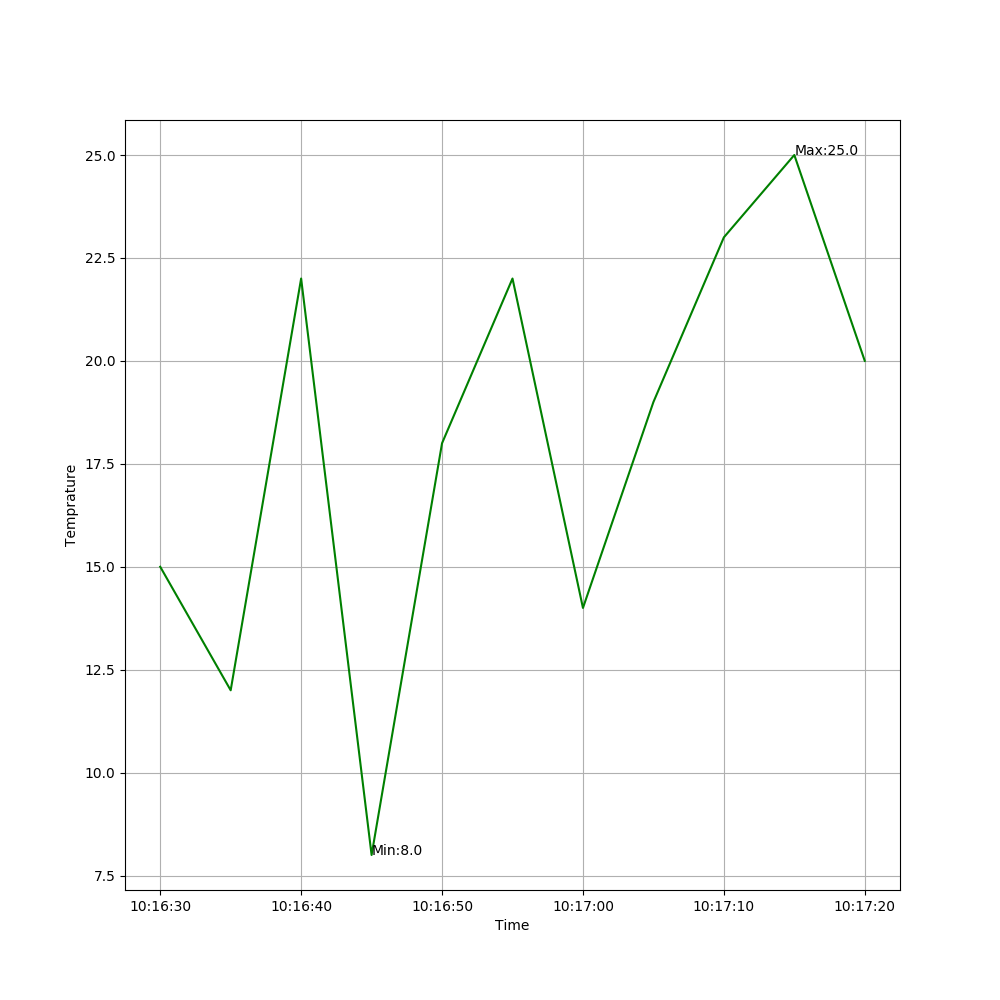

/home/student/.local/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


KeyboardInterrupt: 

In [4]:
%matplotlib notebook
consumer = connect_kafka_consumer()
consume_messages_and_plot(consumer)

## (b) Static data visualization
### Reading the data from mongoDb into the pandas dataframe and cleaning the data
- read the two databases onto the pandas dataframe 
- join the datasets on geohashes 
- get the counts of top 10 fire locations 
- plot the graphs

In [26]:
def _connect_mongo(db):
    #for making a connection to mongoDb
    conn = MongoClient()
    return conn[db]


def read_mongo(collection):
    #Read from MongoDb to DataFrame 

    # Connect to MongoDB
    db = _connect_mongo(db="fit5148_assignment_db")

    # query to select all the data present in database
    cursor = db[collection].find()

    # construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    del df['_id']

    return df


### Hotspot historic collection
* Using `regex` for obtaining location data.

In [27]:
hh=read_mongo("hh")  #Database for hotspots
for i  in range(len(hh.location)):   #refining the location column
    hh.location[i]=re.findall(r"\[(.*?)\]",str(hh.location[i]))[0]

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Climate historic collection
* Using `regex` for obtaining location data.

In [28]:
ch=read_mongo("ch")    #Database for climates
for i  in range(len(ch.location)):    #refining the location column
    ch.location[i]=re.findall(r"\[(.*?)\]",str(ch.location[i]))[0]

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Joining the Climate and Hotspot Data on the basis of Time ranges 

In [29]:
#creating time ranges for climate data 
ntl=[]
for x  in ch.creation_time:
    h=x[11:-13]
    m=x[14:-10]
    if int(m[1])<5:
        nm=m[0]+"5"
    else:  #str(int(m[0])+1)
        nm=str(int(m[0])+1)+"0"    
    #ntl.append((dt.datetime.strptime(m[11:-7],"%H:%M:%S")))
    if nm== "60":
        nh=str(int(h)+1)
        nm="00"
        #print(h,nh)
        ntl.append(nh+":"+nm+" hours")
    else:
        ntl.append(h+":"+nm+" hours")
ch["time_g"]=ntl    

In [30]:
#creating time ranges for hotspot data 
htl=[]
for x in hh.creation_time:
    h=x[11:-13]
    m=x[14:-10]
    if int(m[1])<5:
        nm=m[0]+"5"
    else:  #str(int(m[0])+1)
        nm=str(int(m[0])+1)+"0"    
    #ntl.append((dt.datetime.strptime(m[11:-7],"%H:%M:%S")))
    if nm== "60":
        nh=str(int(h)+1)
        nm="00"
        #print(h,nh)
        htl.append(nh+":"+nm+" hours")
    else:
        htl.append(h+":"+nm+" hours")
hh["time_g"]=htl    

In [31]:
gl=[]
for m in hh.location:
    a,b=m.split(",")
    a= float(a)
    b= float(b)
    gl.append(gh.encode(a,b,precision = 5))  #Assigning geohashes
hh["geo-hash"]=gl  

In [32]:
tl=[]
cl=[]
locs=[]
st,cf,at,rh=[],[],[],[]
for i in range(len(ch.time_g)):
    co=0
    for j in range (len(hh.time_g)):
        if ch.time_g[i]==hh.time_g[j]:
            co+=1
        if ch.location[i]==hh.location[j]:
            if ch.location[i] not in locs:
                locs.append(ch.location[i])
    if ch.time_g[i] not in tl:
        tl.append(ch.time_g[i])
        cl.append(co)    

In [33]:
df = pd.DataFrame(
    {'Time': tl,
     'Count': cl
    })

### (i) Bar chart `Time vs. number of fires`

<IPython.core.display.Javascript object>


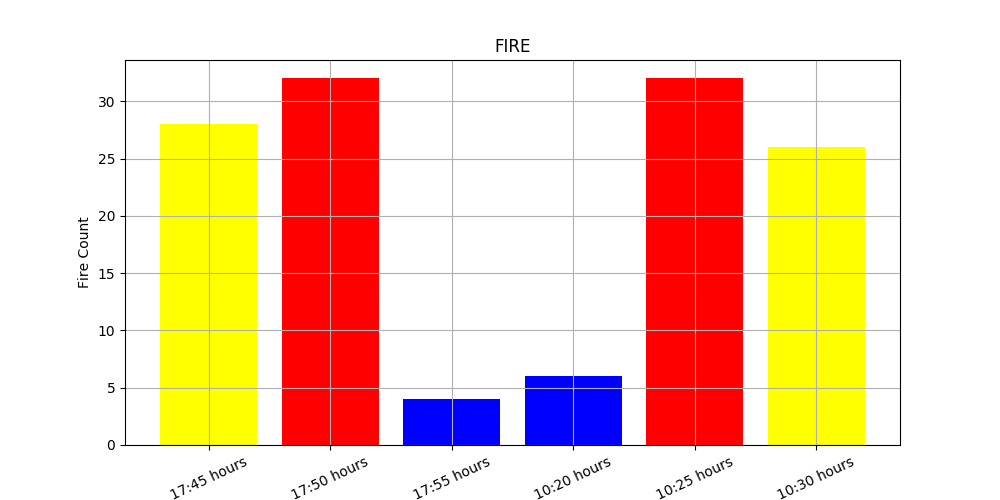

In [34]:
plt.figure(figsize=(10,5))
plt.grid(True)
x= df.Time #The top 10 values
y= df.Count
if len(df)>10:
    x=df.Time[0:10]
    y=df.Count[0:10]
'''for i in range (len(x.values)):
    f=str(x[i])
    x[i]=f[10:-7]    #fetching time data
'''#color coding the data on red yellow and blue    
plt.bar(x, y, color = 'Red')
mask1 = y <= 10
mask2 = y <= 30
mask3 = y >= 30
plt.bar(x[mask3], y[mask3], color = 'Red')
plt.bar(x[mask2], y[mask2], color = 'Yellow')
plt.bar(x[mask1], y[mask1], color = 'blue')


plt.xlabel('Time') 
# naming the y axis 
plt.ylabel('Fire Count') 
plt.title('FIRE')  #giving a title to the graph
plt.xticks(rotation=25)
plt.show() #show the plot'''

### (ii) Fire locations in map

In [35]:
#joining on local hash air temperature, surface
#temperature, relative humidity and confidence. 
loc, st, rh, cf, at, coul = [], [], [], [], [], []

for i in range(len(ch["geo-hash"])):
    c=0
    for j in range(len(hh["geo-hash"])):
        if ch["geo-hash"][i]==hh["geo-hash"][j]:
            c+=1
            coul.append(c)
            loc.append(ch["location"][i])
            st.append(hh.surface_temperature[j])
            rh.append(ch.relative_humidity[i])
            cf.append(hh.confidence[j])
            at.append(ch.air_temperature[i])

In [36]:
ldf = pd.DataFrame(
    {'location': loc,
     'surface_temp': st,
     'relative_humidity': rh,
     'confidence': cf,
     'air_temp': at,
     'count': coul
    })
ldf.sort_values("count",ascending=False,inplace=True)
ldf.reset_index(inplace=True)

In [37]:
m = folium.Map(
    location=[-37.4713, 144.7852],
    zoom_start=7,
    #tiles='Stamen Terrain'
)

for i in range(len(ldf)):
    dd=str(ldf.location[i])
    g,h=dd.split(",")
    g=float(g)
    #print(g)
    h=float(h)
   
    folium.Marker(
        location=[g,h],popup="Surface Temprature: "+str(ldf.surface_temp[i])+" Confidence: "+str(ldf.confidence[i])+" Air Temp: "+str(ldf.air_temp[i]) +" Relative Humidity: "+str(ldf.relative_humidity[i]),icon=folium.Icon(icon='point',color='red'),
       ).add_to(m)
# popup="Surface Temprature: "+str(ndf.surface_temperature[i])+" Confidence: "+str(ndf.confidence[i])+" Air Temp: "+str(ndf.air_temperature[i]) +" Relative Humidity: "+str(ndf.relative_humidity[i]),icon=folium.Icon(icon='point',color='red'),

In [38]:
m